<font color="green">**Linear Regression model for stock prediction using stock data and semantic scores**</font>

**Import Libraries**

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd

#Data Scaling Library
from sklearn.preprocessing import MinMaxScaler

#Error Metrics Library
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#Data Visualization Library
plt.style.use('fivethirtyeight')

**Get stock data and visualize**

In [ ]:
#Get the stock quote for Disney
df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-05-26') 

#Use the below code to get stock quotes for other companies: Apple, AMD, Tesla
#df = web.DataReader('AAPL', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('AMD', data_source='yahoo', start='2016-07-22', end='2020-10-30')
#df = web.DataReader('TSLA', data_source='yahoo', start='2016-07-22', end='2020-10-30')

#Show the data 
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98
2016-07-27,6.98,6.68,6.93,6.85,38567300,6.85
2016-07-28,6.98,6.74,6.79,6.82,27515600,6.82


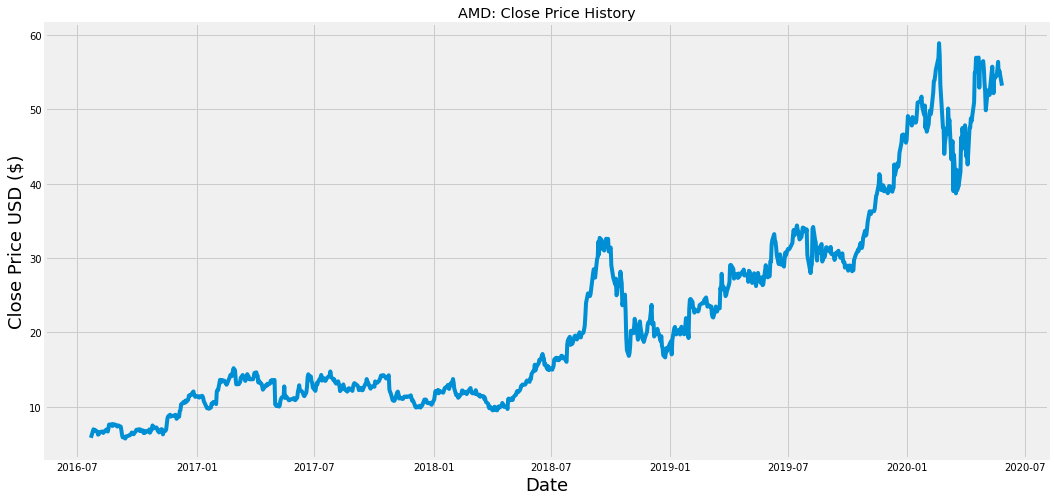

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('AMD: Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess data and split into train-test datasets**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

print("Training Data Length: ", training_data_len)

Training Data Length:  774


In [ ]:
#Scale the all of the data to be values between 0 to 1 range
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
x_train.shape

(714, 60)

In [ ]:
x_test.shape

(193, 60)

**Linear Regression: Build model and train using the training data**

In [ ]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
x_train=x_train.reshape(714, 60)

model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
x_test=x_test.reshape(193, 60)

**Predict on testing data and visualize predictions**

In [ ]:
preds = model.predict(x_test)
preds = preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)#Undo scaling

rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
print("RMS: ",rms)

RMS:  1.685101953314065


In [ ]:
#Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


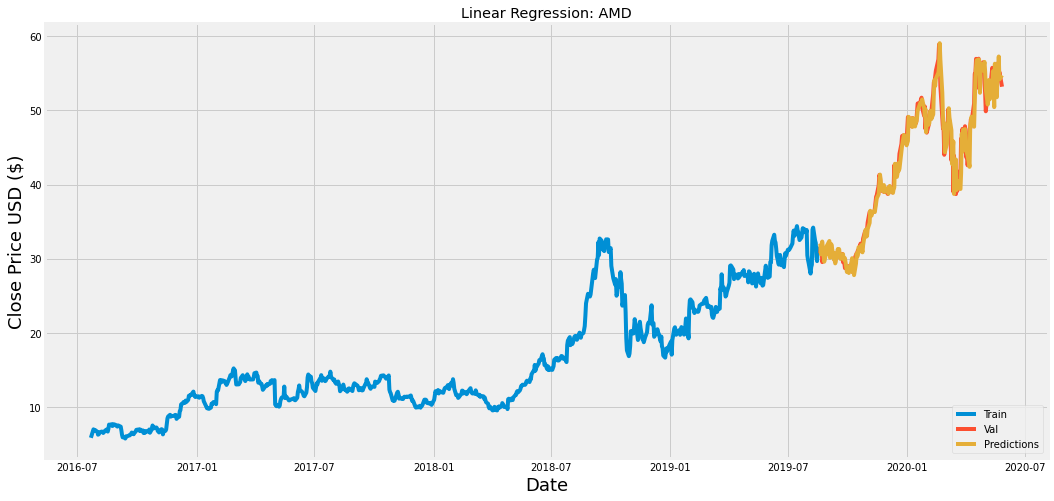

In [ ]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Linear Regression: AMD')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

**Apply R2 Cross Validation**

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [ ]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1, 14))}]

# step-2: perform grid search
# 2.1 specify model

rfe = RFE(model,5)             

# 2.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train, y_train)   

Fitting 50 folds for each of 13 candidates, totalling 650 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 650 out of 650 | elapsed:  1.2min finished


GridSearchCV(cv=KFold(n_splits=50, random_state=100, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=5, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [ ]:
cross_validation_preds = model_cv.predict(x_test)
cross_validation_preds = cross_validation_preds.reshape(-1,1)
cross_validation_preds = scaler.inverse_transform(cross_validation_preds)#Undo scaling

rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(cross_validation_preds)),2)))
print("RMS: ",rms)

RMS:  1.6241153225878384


In [ ]:
#Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = cross_validation_preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


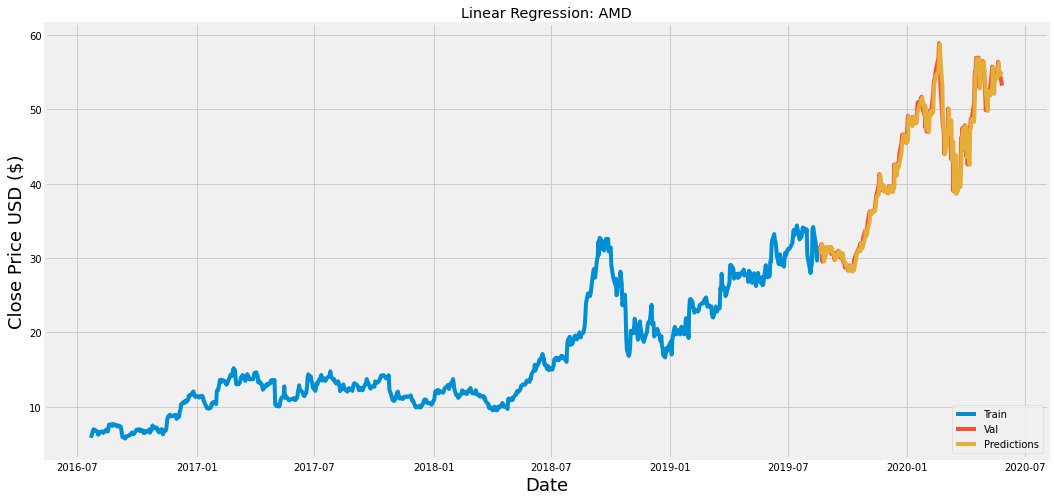

In [ ]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Linear Regression: AMD')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<font color="green">**Linear Regression model for stock prediction using stock data and semantic scores data**</font>

**Get semantic scores data and preprocess**

In [ ]:
#Read semantic scores data from file
newsScores=pd.read_csv('amd-scores.csv')
newsScores.head(3)

,date,final_semantic_score
0,2016-07-22,0.291504
1,2016-07-23,NaN
2,2016-07-24,NaN


In [ ]:
#Impute missing values
newsScores=newsScores.ffill(axis=0)
newsScores.head(3)

,date,final_semantic_score
0,2016-07-22,0.291504
1,2016-07-23,0.291504
2,2016-07-24,0.291504


In [ ]:
df1=df.reset_index()
df1.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98


In [ ]:
newsScores.dtypes

date                     object
final_semantic_score    float64
dtype: object

In [ ]:
newsScores['date'] = pd.to_datetime(newsScores['date'])

**Merge stock data with semantic scores data and visualize**

In [ ]:
#Merge two datasets
merged_data = pd.merge(left=df1, right=newsScores, left_on='Date', right_on='date') #merge datasets
merged_data.drop(['date'], axis=1,inplace=True) #remove redundant column
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,final_semantic_score
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,0.291504
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70,0.291504
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98,0.291504


In [ ]:
merged_data.set_index('Date')
merged_data.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,final_semantic_score
0,2016-07-22,5.97,5.45,5.73,5.84,101838300,5.84,0.291504
1,2016-07-25,6.95,5.92,5.93,6.70,118328600,6.70,0.291504
2,2016-07-26,7.16,6.71,6.76,6.98,81230600,6.98,0.291504


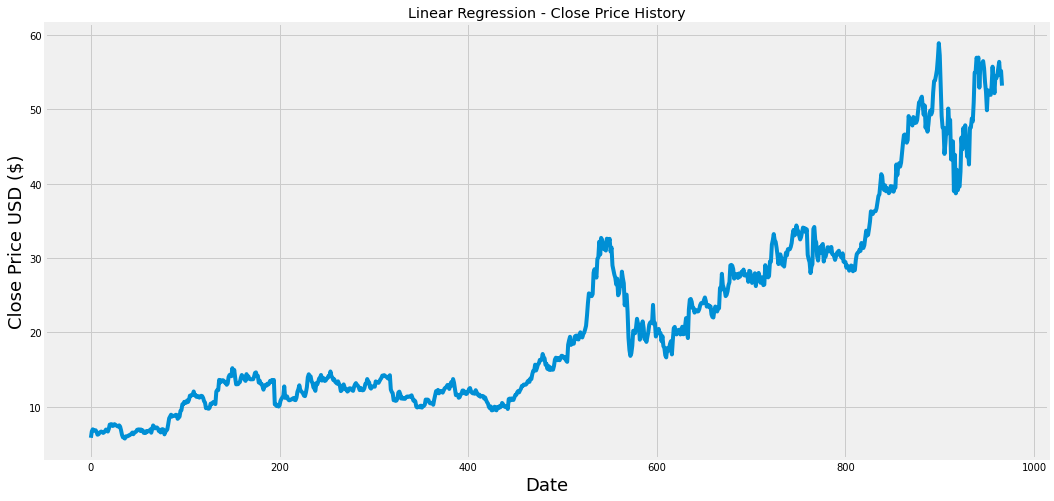

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Linear Regression - Close Price History')
plt.plot(merged_data['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess merged data and split into train-test datasets**

In [ ]:
#Create a new dataframe with only the 'Close' column
data = merged_data.filter(['Close', 'Open','final_semantic_score'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,:])
  y_train.append(dataset[i,0])

In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  df['Close'][training_data_len :]
# y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,:])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

**Linear Regression: Build model and train using the training datat**

In [ ]:
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
nsamples_test, nx_test, ny_test = x_test.shape
x_test = x_test.reshape((nsamples_test,nx_test*ny_test))

**Predict on testing data and visualize predictions**

In [ ]:
preds = model.predict(x_test)
preds = preds.reshape(-1,1)
# preds = scaler.inverse_transform(preds)#Undo scaling

rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
print("RMS: ",rms)

RMS:  12.762211164966455


In [ ]:
#Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


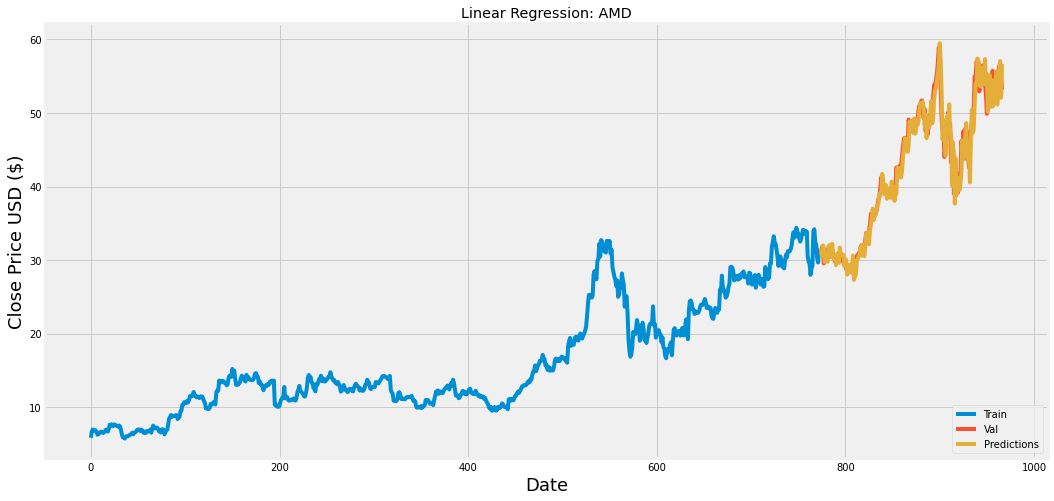

In [ ]:
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Linear Regression: AMD')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()